MIT License

Copyright (c) 2024 ewilkin-star

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

#Titanic Dataset - Best Model

## Importing Packages and Loading Data

Importing all necessary packages for modeling & visualizations

In [157]:
import pandas as pd # For reading in and altering the dataframes
import numpy as np
import matplotlib.pyplot as plt # For plotting the ROC curve
import seaborn as sns # For confusion matrix
from sklearn.ensemble import RandomForestClassifier # For random forest
from sklearn.model_selection import train_test_split # For splitting the data
from sklearn.metrics import accuracy_score # For evaluating the model
from sklearn.metrics import roc_auc_score, roc_curve # For plotting the ROC curve
from sklearn.metrics import confusion_matrix # For plotting the confusion matrix
from sklearn.metrics import precision_recall_curve # For plotting the Precision-Recall curve
from sklearn.model_selection import learning_curve # For plotting the learning curve

Obtaining Version Information

In [158]:
# Version information:

import sys
import sklearn
import matplotlib
import seaborn

version = ".".join(map(str, sys.version_info[:3]))
print("Versions:")
print("Python: ", version)
print("sklearn: ", sklearn.__version__)
print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("seaborn: ", seaborn.__version__)

Versions:
Python:  3.10.12
sklearn:  1.5.2
pandas:  2.2.2
numpy:  1.26.4
matplotlib:  3.8.0
seaborn:  0.13.2


Loading Training Dataset

In [159]:
train_data = pd.read_csv("train.csv")

Listing Columns in Training Data

In [160]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Training the Model

Creating dummy variables for categorical data

In [161]:
# Getting dummy variables.
# Dropping features that were not used in achieving this test score.

X_train = pd.get_dummies(train_data, columns=["Sex", "Pclass"], drop_first = True)
X_train.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin", "Embarked", "SibSp", "Parch", "Pclass_2"], axis=1, inplace=True)

y_train = train_data["Survived"]

To achieve the highest test score from our model training, only four features were used: "Age", "Fare", "Sex_male" (dummy for "Sex"), and "Pclass_3" (dummy for class 3; class 2 was not as important of a feature).

Separating validation data

In [162]:
# Splitting the data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1
)

Code to find number of rows in each dataset

In [163]:
# Number of rows in each dataset
print(f"Training: {X_train_split.shape[0]}")
print(f"Validation: {X_val.shape[0]}")

Training: 712
Validation: 179


Training the RandomForestClassifier

In [164]:
# Training the model
model = RandomForestClassifier(max_depth=6, min_samples_split=40, random_state=1)
model.fit(X_train_split, y_train_split)

RandomForestClassifier(max_depth=6, min_samples_split=40, random_state=1)

## Evaluating the Model: Accuracy and AUC

Obtaining Training and Validation Accuracy

In [165]:
# Making predictions on both training and validation
train_predictions = model.predict(X_train_split)
val_predictions = model.predict(X_val)

# Calculating accuracy
train_accuracy = accuracy_score(y_train_split, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)

# Printing both accuracies
print(f"Training Accuracy: {train_accuracy:.6f}")
print(f"Validation Accuracy: {val_accuracy:.6f}")

Training Accuracy: 0.855337
Validation Accuracy: 0.759777


Obtaining predictions on "test.csv" in order to submit to kaggle and recieve test accuracy

In [166]:
# Test data to submit to kaggle for test accuracy
test_data = pd.read_csv("test.csv")
X_test = pd.get_dummies(test_data, columns=["Sex", "Pclass"], drop_first=True)
X_test.drop(["PassengerId", "Name", "Ticket", "Cabin", "Embarked", "SibSp", "Parch", "Pclass_2"], axis=1, inplace=True)

# Make predictions
test_predictions = model.predict(X_test)

# Create dataframe with PassengerId and predictions
submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": test_predictions
})

# CSV file for Kaggle submission
submission.to_csv("titanic_test_data_predictions.csv", index=False)

print("Kaggle's score for the test dataset: 0.78229")

Kaggle's score for the test dataset: 0.78229


Obtaining training and validation AUC (kaggle does not provide test AUC)

In [167]:
# Calculate AUC for training and validation data
y_train_prob = model.predict_proba(X_train_split)[:, 1]
train_auc = roc_auc_score(y_train_split, y_train_prob)

y_val_prob = model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_val_prob)

# Create and display the table with results
auc_data = {
    'Train AUC': [train_auc],
    'Validation AUC': [val_auc]
}

auc_table = pd.DataFrame(auc_data)
print(auc_table)

   Train AUC  Validation AUC
0    0.91887        0.833096


Plotting the ROC Curve

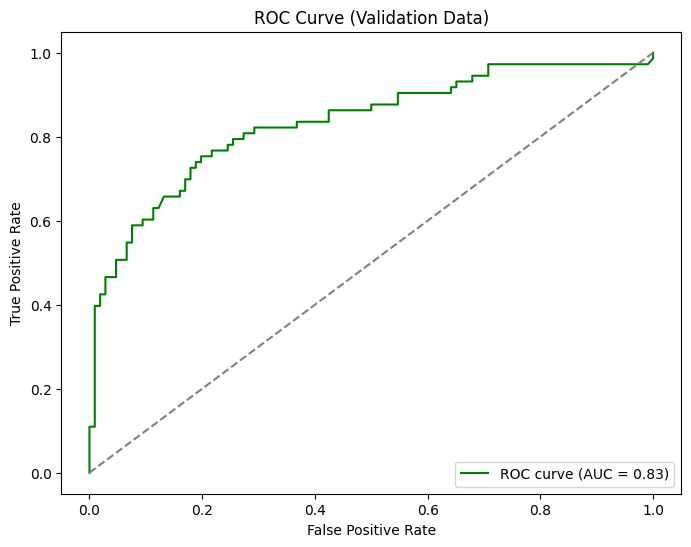

In [168]:
# Plot the ROC curve for validation data
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='g', label=f'ROC curve (AUC = {val_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Validation Data)')
plt.legend(loc='lower right')
plt.show()

## Evaluating the Model: AIR

Creating a dataset that contains predictions in order to calculate AIR

In [169]:
# Adding predictions to training data in order to calculate AIR
training_with_predictions = X_train_split.copy()
training_with_predictions['predictions'] = model.predict(training_with_predictions)

print(training_with_predictions.head())

      Age     Fare  Sex_male  Pclass_3  predictions
301   NaN  23.2500      True      True            0
309  30.0  56.9292     False     False            1
516  34.0  10.5000     False     False            1
120  21.0  73.5000      True     False            0
570  62.0  10.5000      True     False            0


AIR Calculations for Sex

In [170]:
# Calculate the selection rate for females (protected group) and males (control group)
female_selection_rate = training_with_predictions[training_with_predictions['Sex_male'] == False]['predictions'].mean()
male_selection_rate = training_with_predictions[training_with_predictions['Sex_male'] == True]['predictions'].mean()

# AIR Calculation
air = female_selection_rate / male_selection_rate

print(f"Female Selection Rate: {female_selection_rate:.4f}")
print(f"Male Selection Rate: {male_selection_rate:.4f}")
print(f"AIR: {air:.4f}")

Female Selection Rate: 0.7631
Male Selection Rate: 0.0432
AIR: 17.6647


Visualizing Selection Rate between Sexes

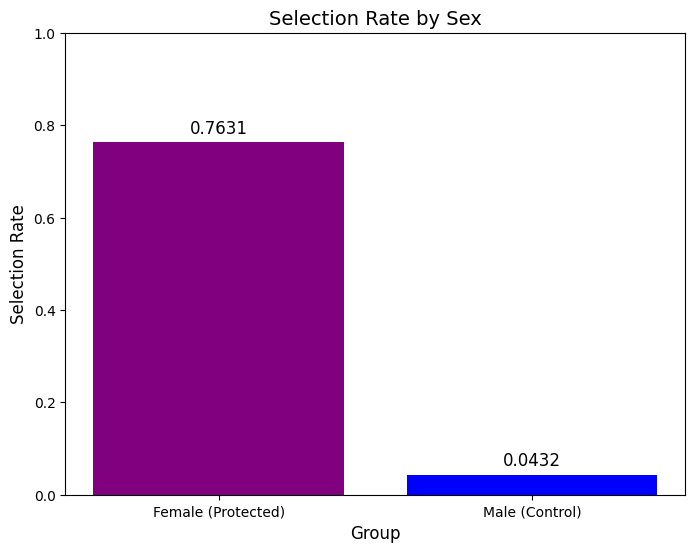

In [171]:
# Creating Labels and Variable for selection rate of each sex
labels = ['Female (Protected)', 'Male (Control)']
selection_rates = [female_selection_rate, male_selection_rate]

# Creating the plot
plt.figure(figsize=(8, 6))
plt.bar(labels, selection_rates, color=['purple', 'blue'])

# Titles and labels
plt.title('Selection Rate by Sex', fontsize=14)
plt.ylabel('Selection Rate', fontsize=12)
plt.ylim(0, 1)
plt.xlabel('Group', fontsize=12)

# Display  selection rates
plt.text(0, female_selection_rate + 0.02, f'{female_selection_rate:.4f}', ha='center', fontsize=12)
plt.text(1, male_selection_rate + 0.02, f'{male_selection_rate:.4f}', ha='center', fontsize=12)

plt.show()

Finding the AIR between 3rd class and the 1st/2nd classes

In [172]:
# Selection rate for class 3 (protected group) and classes 1/2 (control)
class_3_selection_rate = training_with_predictions[training_with_predictions['Pclass_3'] == True]['predictions'].mean()
non_class_3_selection_rate = training_with_predictions[training_with_predictions['Pclass_3'] == False]['predictions'].mean()

# Calculate AIR
air_class_3 = class_3_selection_rate / non_class_3_selection_rate

print(f"Class 3 Selection Rate: {class_3_selection_rate:.4f}")
print(f"Classes 1 and 2 Selection Rate: {non_class_3_selection_rate:.4f}")
print(f"Adverse Impact Ratio (AIR) for Pclass_3: {air_class_3:.4f}")


Class 3 Selection Rate: 0.1546
Classes 1 and 2 Selection Rate: 0.4630
Adverse Impact Ratio (AIR) for Pclass_3: 0.3340


Visualizing AIR for classes

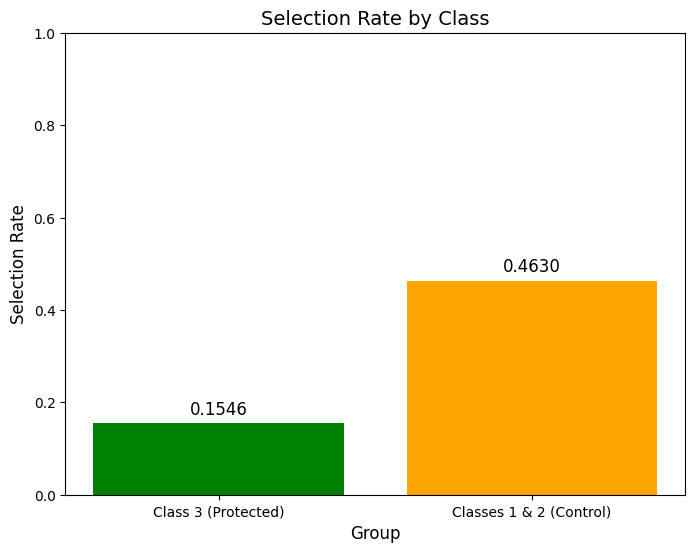

In [173]:
# Creating Labels and Variable for selection rate of each class
labels = ['Class 3 (Protected)', 'Classes 1 & 2 (Control)']
selection_rates = [class_3_selection_rate, non_class_3_selection_rate]

# creating the plot
plt.figure(figsize=(8, 6))
plt.bar(labels, selection_rates, color=['green', 'orange'])

# titles and labels
plt.title('Selection Rate by Class', fontsize=14)
plt.ylabel('Selection Rate', fontsize=12)
plt.ylim(0, 1)
plt.xlabel('Group', fontsize=12)

# Display AIR
plt.text(0, class_3_selection_rate + 0.02, f'{class_3_selection_rate:.4f}', ha='center', fontsize=12)
plt.text(1, non_class_3_selection_rate + 0.02, f'{non_class_3_selection_rate:.4f}', ha='center', fontsize=12)

plt.show()

## Evaluating the Model: Confusion Matrix, Feature Importance and Learning Curve

Creating the Confusion Matrix for the Validation Dataset

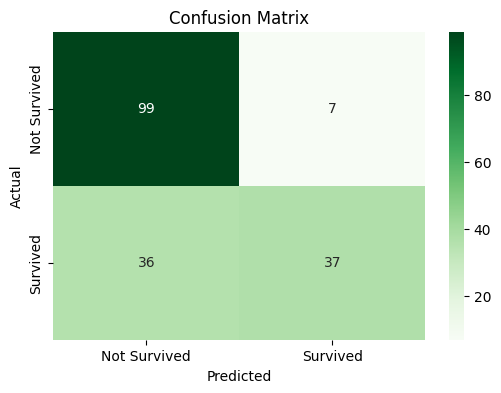

In [174]:
# Predict on the validation set
y_val_pred = model.predict(X_val)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=["Not Survived", "Survived"], yticklabels=["Not Survived", "Survived"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Obtaining Feature Importances and Creating the Feature Importance Plot

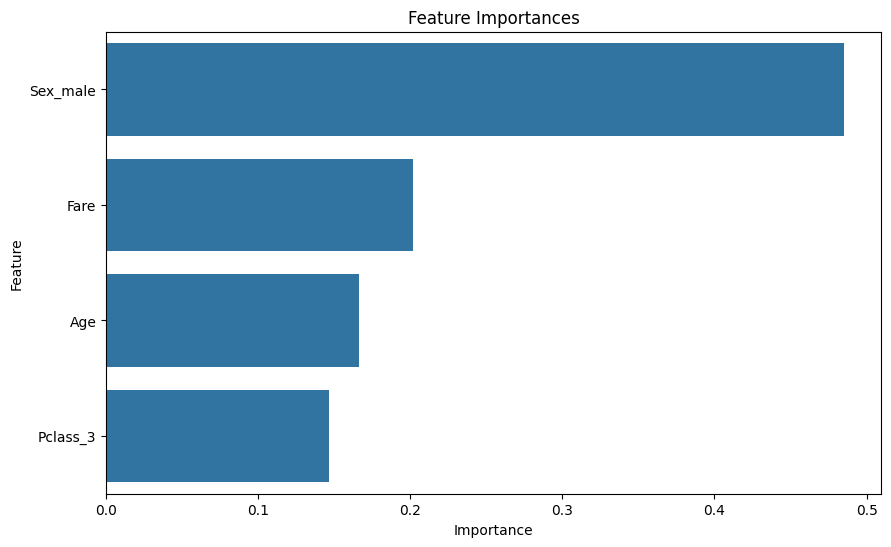

In [175]:
# Get feature importances
feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()

Caluclating precision and recall and creating the precision-recall curve

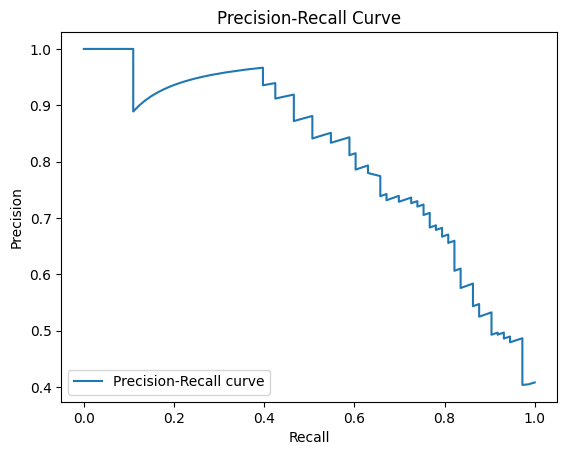

In [176]:
# Compute precision recall
precision, recall, _ = precision_recall_curve(y_val, y_val_prob)

# Plot
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

Calculating the learning curve and plotting

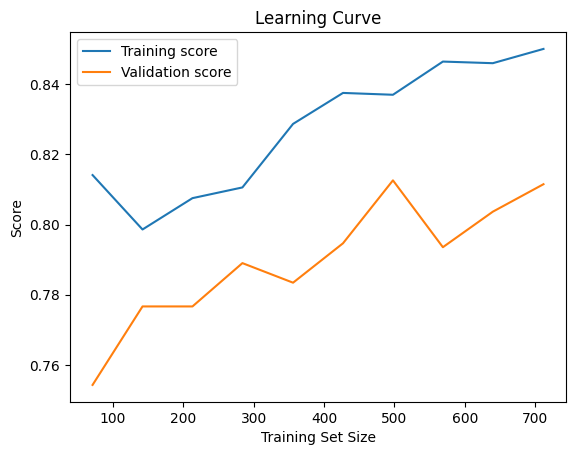

In [177]:
# Compute learning curve
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
)

# Plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation score')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()